In [ ]:
!pip install -q open_clip_torch timm einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.1 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="processing_llava.py", local_dir="./", force_download=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


configuration_llava.py:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_llava.py:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

processing_llava.py:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

'./processing_llava.py'

In [ ]:
from modeling_llava import LlavaForConditionalGeneration
import torch

model = LlavaForConditionalGeneration.from_pretrained("visheratin/LLaVA-3b", torch_dtype=torch.float16)
model = model.to("cuda")

No module named 'flash_attn'
Not using Flash Attention!


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("visheratin/LLaVA-3b")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from processing_llava import LlavaProcessor, OpenCLIPImageProcessor
from modeling_llava import LlavaConfig

config = LlavaConfig.from_pretrained("visheratin/LLaVA-3b")

image_processor = OpenCLIPImageProcessor(config.preprocess_config, max_tokens=config.max_image_tokens, crop_size=config.preprocess_config["size"])
processor = LlavaProcessor(image_processor, tokenizer)

In [ ]:
from PIL import Image
import requests

image_file = "https://images.unsplash.com/photo-1439246854758-f686a415d9da"
raw_image = Image.open(requests.get(image_file, stream=True).raw)

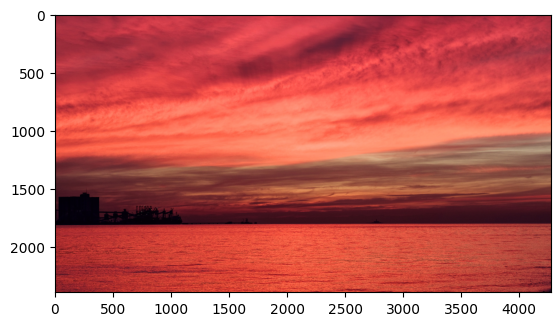

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(raw_image)
plt.show()

In [ ]:
prompt = """<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
<|im_start|>user
<image>
Describe the image.<|im_end|>
<|im_start|>assistant
"""

In [ ]:
with torch.inference_mode():
  inputs = processor(prompt, raw_image, model, return_tensors='pt')

inputs['input_ids'] = inputs['input_ids'].to(model.device)
inputs['attention_mask'] = inputs['attention_mask'].to(model.device)

In [ ]:
from transformers import TextStreamer

streamer = TextStreamer(tokenizer)

In [ ]:
%%time
with torch.inference_mode():
  output = model.generate(**inputs, max_new_tokens=200, do_sample=True, top_p=0.9, temperature=1.2, eos_token_id=tokenizer.eos_token_id, streamer=streamer)

Setting `pad_token_id` to `eos_token_id`:50295 for open-end generation.


<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
<|im_start|>user
<image>
Describe the image.<|im_end|>
<|im_start|>assistant
A large red cargo ship is anchored in a calm water in front of a sunset. The sky is ablaze with red, orange, and yellow colors. There are two tall red columns of clouds behind the ship. The water is dark and still.
<|im_end|>
CPU times: user 4.47 s, sys: 38.8 ms, total: 4.51 s
Wall time: 4.48 s


In [ ]:
print(tokenizer.decode(output[0]).replace(prompt, "").replace("<|im_end|>", ""))

A large red cargo ship is anchored in a calm water in front of a sunset. The sky is ablaze with red, orange, and yellow colors. There are two tall red columns of clouds behind the ship. The water is dark and still.

